In [387]:
%matplotlib inline

########## IMPORTS AND UTILITY FUNCITONS / CLASSES ###########

from __future__ import division
import numpy
import time

#from __future__ import print_function
#from keras.datasets.data_utils import get_file
#import random, sys

import matplotlib.pyplot as plt
#import matplotlib.cm as cm

from __future__ import print_function
import theano as T
import numpy as np
from six.moves import range
from datetime import datetime
import string
from tabulate import tabulate

# Utility class stolen from 3.3
class SimpleNameSpace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
    def __repr__(self):
        keys = sorted(self.__dict__)
        items = ("{}={!r}".format(k, self.__dict__[k]) for k in keys)
        return "{}({})".format(type(self).__name__, ", ".join(items))
    def __eq__(self, other):
        return self.__dict__ == other.__dict__

Testing generate_poisson_clicks()
    Spike vector size is :: (1000, 1)
    Expect 100.00 clicks per second (1.00 seconds)
    Found 115 clicks.

    min :: 0.00
    max :: 1.00
    mean :: 0.12
Shape of a single sequnece :: (2001, 3)
Last 10 samples ::  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


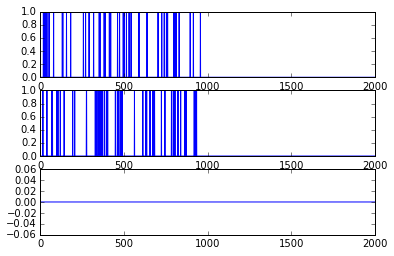

In [388]:
########## STIMULUS GENERATOR FUNCTIONS ###########

def generate_poisson_clicks(click_rate, n_samples=1000 ,sampling_freq=1000, centered=False):
    
    click_vector = numpy.zeros( (n_samples, 1) )
    
    click_times  = numpy.where( numpy.random.uniform(0,1,n_samples) <= (click_rate/sampling_freq))[0]
    
    if centered:
        # bimodal spikes
        click_vector[ click_times[:-1]   ] =   0.5;
        click_vector[ click_times[:-1]+1 ] =  -0.5;
    else:
        # unimodal spikes
        click_vector[ click_times[:-1] ] = 1;                    
                
    return click_vector

def generate_trial_sequence( sum_rate=100, 
                            click_bias=0.5, 
                            stim_duration=1, 
                            wait_time=1, 
                            choice_values=(-1,1), 
                            sampling_freq = 1000, 
                            centered=False):
    # Outputs two poisson click streams + a third response stream
    # Dimensionality of output is [3, n_samples] (ie., each dimension/signal is in a row]
    # The response stream has a single final point that is (by default) -1 if rate(1)>rate(2) or 1 if rate(2)>rate(1)
    stimulus_1_rate = sum_rate - sum_rate * click_bias
    stimulus_2_rate = 0 + sum_rate * click_bias
    stimulus_1  = generate_poisson_clicks( stimulus_1_rate , n_samples=1000, sampling_freq=sampling_freq, centered=centered )
    stimulus_2  = generate_poisson_clicks( stimulus_2_rate , n_samples=1000, sampling_freq=sampling_freq, centered=centered )
    output_stim = numpy.zeros( (stim_duration*sampling_freq,1))
    wait_vector = numpy.zeros( (wait_time*sampling_freq,1))
    stim_1_vector = numpy.concatenate( (stimulus_1,  wait_vector, [[0]]))
    stim_2_vector = numpy.concatenate( (stimulus_2,  wait_vector, [[0]]))
    if stimulus_2_rate == stimulus_1_rate:
        output_choice = [[choice_values[numpy.random.binomial(1,0.5)]]]
    else:
        output_choice = [[choice_values[ stimulus_2_rate > stimulus_1_rate]]]
    output_vector = numpy.concatenate( (output_stim, wait_vector,  output_choice))
    return numpy.concatenate( (stim_1_vector, stim_2_vector,output_vector),1 )

def generate_click_dataset( n_trials, click_biases, **kwargs ):
    # Generates a dataset of clicks of the shape [trials,samples,dims] where
    # dims is probably 2 for X and 1 for Y. Note that this is *fully* psychometric.
    #
    # Pass through kwargs to generate_trial_sequence!
     
    X = numpy.zeros((n_trials,n_samples,2))
    Y = numpy.zeros((n_trials,n_samples,1))
    for i in range(n_trials):
        this_sequence = generate_trial_sequence( 
            click_bias=click_biases[i], **kwargs )
        X[i,:,:] = this_sequence[:,:2]
        Y[i,:,0] = this_sequence[:, 2]
    return (X,Y)

# TESTING

spike_vector = generate_poisson_clicks( click_rate=100, n_samples=1000, sampling_freq=1000, centered=False)
print ('Testing generate_poisson_clicks()')
print ('    Spike vector size is :: %s' %(str(spike_vector.shape)))
print ('    Expect %.2f clicks per second (%.2f seconds)' % ( 100 * (spike_vector.size/1000), (spike_vector.size/1000)))
print ('    Found %.0f clicks.' %( sum(spike_vector == numpy.max(spike_vector))))
print ('')
print ('    min :: %.2f' % (min(spike_vector)))
print ('    max :: %.2f' % (max(spike_vector)))
print ('    mean :: %.2f' % (numpy.mean(spike_vector.ravel())))

## Display a single response.
a = generate_trial_sequence(click_bias=0.5,choice_values=(0,1))
print('Shape of a single sequnece ::',a.shape)
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(a[-10000:-1,i])

print('Last 10 samples :: ',a[-10:,-1])

Datasets generated in 3.4 seconds
X_train.shape :: (20000, 1001, 2)
Y_train.shape :: (20000, 1001, 1)
X_test.shape  :: (2000, 1001, 2)
Y_test.shape  :: (2000, 1001, 1)

N right choices :: 9991 
mean( left clicks  | right trial ) :: 25 
mean( right clicks | right trial ) :: 73 

N left choices  :: 10009 
mean( left clicks  | left trial  ) :: 74 
mean( right cliks  | left trial  ) :: 24 

    min :: 0.00
    max :: 1.00
    mean :: 0.05


(-1.1, 1.1)

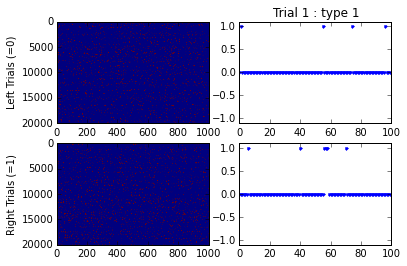

In [389]:
############ SANITY CHECK / DEBUG DATSET  #####################

# Generate a dataset of poisson spikes.  Basically just calls generate_click_dataset.
# X_train is set up as n_samples, n_dimensions=2, n_timepoints
# Y_Train is set up as n_samples, n_dimensions=1, n_timepoints
# Cost function will have to match Y_train (ie., only match the end)

n_trials_train = 20000
n_trials_test  = 2000
stim_duration  = 1
wait_time      = 0
sampling_freq  = 1000
sum_rate       = 100
n_samples = (stim_duration+wait_time)*sampling_freq + 1
choice_values = (-1,1) # 

#click_bias_train = numpy.random.normal(0.5,0.2,(n_trials_train))
#click_bias_test = numpy.random.normal(0.5,0.2,(n_trials_test))
#click_bias_train[click_bias_train <= 0.1] = 0.1
#click_bias_test[click_bias_test <= 0.1]   = 0.1

click_bias_train = numpy.random.uniform( 0, 1, (n_trials_train))
click_bias_test  = numpy.random.uniform( 0, 1, (n_trials_test) )

t_start = time.time()
(X_train,Y_train) = generate_click_dataset( n_trials_train, 
                                           click_bias_train, 
                                           sum_rate=sum_rate, 
                                           stim_duration=stim_duration, 
                                           wait_time=wait_time, 
                                           sampling_freq=sampling_freq, 
                                           centered=False)
(X_test,Y_test)   = generate_click_dataset( n_trials_test,  
                                           click_bias_test,  
                                           sum_rate=sum_rate, 
                                           stim_duration=stim_duration, 
                                           wait_time=wait_time, 
                                           sampling_freq=sampling_freq, 
                                           centered=False)

# Center
#X_train = X_train - numpy.mean(X_train.ravel())
#X_test  = X_test - numpy.mean(X_test.ravel())

print('Datasets generated in %.1f seconds' %( time.time() - t_start))
print('X_train.shape :: %s' %(str(X_train.shape)))
print('Y_train.shape :: %s' %(str(Y_train.shape)))
print('X_test.shape  :: %s' %(str(X_test.shape)))
print('Y_test.shape  :: %s' %(str(Y_test.shape)))
print(''     )
print('N right choices :: %.0f ' % (sum(Y_train[:,-1,0] == 1)))

left_trials  = Y_test[:,-1,0] == choice_values[0]
right_trials = Y_test[:,-1,0] == choice_values[1]
print ('mean( left clicks  | right trial ) :: %.0f ' % ( numpy.mean(numpy.sum(X_test[ right_trials , :(sampling_freq*stim_duration),0], axis=1)) ))
print ('mean( right clicks | right trial ) :: %.0f ' % ( numpy.mean(numpy.sum(X_test[ right_trials , :(sampling_freq*stim_duration),1], axis=1)) ))
print ('')
print ('N left choices  :: %.0f ' % (sum(Y_train[:,-1,0] == -1)))
print ('mean( left clicks  | left trial  ) :: %.0f ' % ( numpy.mean(numpy.sum(X_test[ left_trials , :(sampling_freq*stim_duration),0], axis=1)) ))
print ('mean( right cliks  | left trial  ) :: %.0f ' % ( numpy.mean(numpy.sum(X_test[ left_trials , :(sampling_freq*stim_duration),1], axis=1)) ))
print ('')
print ('    min :: %.2f' % (min(X_test.ravel())))
print ('    max :: %.2f' % (max(X_test.ravel())))
print ('    mean :: %.2f' % (numpy.mean(X_test.ravel())))

plt.subplot(2,2,1)
plt.imshow(X_train[:,:,0],aspect='auto')
plt.ylabel('Left Trials (=0)')

plt.subplot(2,2,3)
plt.imshow(X_train[:,:,1],aspect='auto')
plt.ylabel('Right Trials (=1)')

plt.subplot(2,2,2)
plt.plot(X_train[0,:100,0],'.')
plt.ylim((-1.1,1.1))
plt.title('Trial 1 : type %.0f' %(Y_train[0,-1,0]))

plt.subplot(2,2,4)
plt.plot(X_train[0,:100,1],'.')
plt.ylim((-1.1,1.1))


In [170]:
# TODO 7/2015 :: Figure out why the .ipynb has to be in ~/keras 
# (and NOT ~/notebooks, and NOT ~/keras/keras, and NOT ~/keras/keras/notebooks)
# in order to run from keras.optimizers import HF
# UPDATE 12/2015 :: I think I over-wrote this code so it doesn't matter any more.
#from keras.optimizers import SGD
#from keras.optimizers import HF

In [554]:

####### Function to define model #########

def define_and_compile_model(params):
    
    # Print parameters
    params_str = str(params)
    print( 'Compiling with parameters as follows:')
    print( tabulate(string.split(p,'=') for p in string.split(params_str[9:-1],',')))
    
   
    ####### Initialize inner weights of RNN #####

    def normal_radius(shape,scale=1):
        normal_init = np.random.randn(*shape)
        radius_init = max(abs(sp.linalg.eigvals(normal_init)))
        return K.variable( normal_init / radius_init * scale )

    if params.rnn_inner_init_type == 'identity':
        rnn_inner_init = identity
    elif params.rnn_inner_init_type == 'normal_radius':
        rnn_inner_init = normal_radius
    elif params.rnn_inner_init_type == 'orthogonal':
        rnn_inner_init = orthogonal
    else:
        raise Exception('params.rnn_inner_init_type not found')

    ####### Initialize Final Layer #######

    if params.final_layer_type == 'dense_hingeloss':
        final_layer = Dense(1, init=lambda shape: normal(shape,scale=0.1))
        loss_fn = 'hinge'
        optimizer_choice_values = (-1,1)
    elif params.final_layer_type == 'softmax_binary_crossentropy':
        final_layer = Dense(1,activation='softmax',init=lambda shape: normal(shape,scale=0.1))
        loss_fn = binary_crossentropy
        optimizer_choice_values = (0,1)
    elif params.final_layer_type == 'sigmoid_hingeloss':
        final_layer = Dense(1,activation='sigmoid', init=lambda shape: normal(shape,scale=0.1))
        loss_fn = 'hinge'
        optimizer_choice_values = (0,1)
    else:
        raise Exception('params.final_layer_type not found :: ',params.final_layer_type)
        

    ####### Define loss and optimizer for model ######

    def two_afc_loss(y_true, y_pred):
        # Possible contributions to loss
        mean_pre_output  = T.mean(abs(y_pred[:-1]))
        not_rewarded = 1 - ( T.gt( y_true[-1] * y_pred[-1] , abs(y_true[-1]) ) ) # change 1 --> abs(y_true[-1])
        binary_choice_error = 1 - T.gt(abs(y_pred[-1]-y_true[-1]),0) # 0 if correct, 1 if incorrect
        abs_choice_error = abs(y_true[-1] - y_pred[-1])           # abs magnitude of error
        # Output loss :: we include a T.zeros_like to make sure that our objective is appropriately broadcast to the size of the original inputs.
        return abs_choice_error + T.zeros_like(y_true) # convert to a loss function, where 1 is a failed trial

    if params.optimizer == 'SGD':
        #optimizer = optimizers.SGD(lr=1e-4, decay=1e-5, momentum=0.99, nesterov=True)
        optimizer = optimizers.SGD(lr=params.sgd_lr, decay=params.sgd_decay, momentum=params.sgd_momentum, nesterov=params.sgd_nesterov)
    elif params.optimizer == 'RMSprop':
        # Leave at default I guess?
        optimizer = optimizers.RMSprop()
    else:
        raise Exception('params.optimizer not found :: ', params.optimizer)

    ####### Define model ######

    print('Building  model...')

    model = Sequential()
    model.add( recurrent.SimpleRNN( params.rnn_1_hidden_dim,
                                   input_shape      = (None,2),
                                   activation       = 'relu',
                                   return_sequences = False,
                                   init             = lambda shape: normal(shape,scale=params.rnn_init_scale),
                                   inner_init       = lambda shape: rnn_inner_init(shape,scale=params.rnn_inner_scale),
                                   ))
    model.add(Dropout(0.5))
    
    # Add final layer.
    model.add( final_layer )
        # old ::
#     model.add(Dense(1,activation='sigmoid'))
#     if params.final_layer_type == 'dense_hingeloss':
#         model.add(Dense(1,activation='sigmoid'))
#     elif params.final_layer_type == 'softmax_categorical_crossentropy':
#         model.add( Dense(1,init=normal(scale=0.1),)
#         model.add( Activation('softmax') )
#     elif params.final_layer_type == 'sigmoid_hingeloss':
#         model.add( Dense(1) )
#         model.add( Activation('sigmoid'))


    ######## Compile ########
    print('Compiling')
    model.compile(loss=loss_fn, optimizer=optimizer)
    print('...done compiling at ',datetime.now())

    return model

In [ ]:
###########################################
########## BUILD AND RUN MODEL ############
###########################################


from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import recurrent
import keras.optimizers as optimizers
from keras.objectives import hinge, binary_crossentropy
from keras.initializations import normal,identity,orthogonal
from keras import backend as K

##### PARAMETERS #########
# Hyperparameters to search
# - RNN hidden intialization.  Something around 1-1.1 is reasonable.
#     -> implemented as rotation(identity * [1..1.1]), but vary rotation
#     -> implemented
#
# - RNN input initialization.  Gaussian(0.1) ish?
#     - input as init = normal(shape, scale=0.05)
#
# - Centering using mean-subtraction.  This is actually a signal, so be careful.
#     - X_train = X_train - mean()
#    for row in range(a.shape[0]):
#        a[row,:,:] = a[row,:,:] - np.mean( a[row,:,:] )
#    --> implemented ++
#
# TODO
# - validation holdout set.
# - softmax gives very bad values (-16 forever?)
#

params = SimpleNameSpace()

params.rnn_1_input_dim               = 2
params.rnn_1_hidden_dim              = 256 # = number of hidden units.

params.rnn_init_scale                = 0.01 # Normal, scaled by sigma (std).  ~0.001ish might be reasonable.
params.rnn_inner_init_type           = 'identity' 
#params.rnn_inner_init_type           = 'normal_radius' 
#params.rnn_inner_init_type           = 'orthogonal'
params.rnn_inner_scale               = 1

params.final_layer_type              = 'dense_hingeloss'
#params.final_layer_type              = 'sigmoid_hingeloss'
#params.final_layer_type              = 'softmax_binary_crossentropy'
params.dense_input_dim               = rnn_1_hidden_dim
params.dense_output_dim              = 1

#params.optimizer                     = 'SGD'
#params.sgd_lr                        = 1e-4
#params.sgd_decay                     = 1e-5
#params.sgd_momentum                  = 0.995
#params.sgd_nesterov                  = True

params.optimizer                    = 'RMSprop'

params.do_center_X                   = 1



############## GENERATE DATA #############

n_trials_train = 20000
n_trials_test  = 2000
stim_duration  = 1
wait_time      = 0
sampling_freq  = 1000
sum_rate       = 200
n_samples = (stim_duration+wait_time)*sampling_freq + 1

if params.final_layer_type   == 'dense_hingeloss':             choice_values = (-1, 1)
elif params.final_layer_type == 'softmax_binary_crossentropy': choice_values = ( 0, 1)
elif params.final_layer_type == 'sigmoid_hingeloss':           choice_values = ( 0, 1)
else: raise Exception('params.final_layer_type not found :: ',params.final_layer_type)


print('Generating datasets...')
t_start = time.time()
click_bias_train = numpy.random.uniform( 0, 1, (n_trials_train))
click_bias_test  = numpy.random.uniform( 0, 1, (n_trials_test) )
(X_train,Y_train) = generate_click_dataset( n_trials_train,  click_bias_train, sum_rate=sum_rate, stim_duration=stim_duration, wait_time=wait_time, sampling_freq=sampling_freq, centered=False,choice_values=choice_values)
(X_test,Y_test)   = generate_click_dataset( n_trials_test,  click_bias_test,  sum_rate=sum_rate, stim_duration=stim_duration,  wait_time=wait_time,  sampling_freq=sampling_freq, centered=False,choice_values=choice_values)
print('Datasets generated in %.1f seconds' %( time.time() - t_start))

if params.do_center_X:
    print('Centering datasets...')
    for row in range(X_train.shape[0]):
        X_train[row,:,:] = X_train[row,:,:] - np.mean( X_train[row,:,:] )
    for row in range(X_test.shape[0]):
        X_test[row,:,:] = X_test[row,:,:] - np.mean( X_test[row,:,:] )
        
############## Sanity check on inputs #############

#(nb_samples, timesteps, input_dim)
print('X_train.shape :: ',X_train.shape)
print('Y_train full :: ',Y_train.shape)
print('Y_train last :: ',numpy.squeeze(Y_train[:,-1,:]))
print('Targeting choice values ',choice_values,'with final layer :: ',params.final_layer_type)

####### Compile the actual model #########

model = define_and_compile_model(params)

# ############# Begin training #############
print('Starting training at ',datetime.now())
history = model.fit(X_train, numpy.squeeze(Y_train[:,-1,:]), 
          nb_epoch=50, batch_size=16, 
          shuffle = 1)


Generating datasets...
Datasets generated in 3.5 seconds
Centering datasets...
X_train.shape ::  (20000, 1001, 2)
Y_train full ::  (20000, 1001, 1)
Y_train last ::  [ 1.  1.  0. ...,  1.  1.  1.]
Targeting choice values  (0, 1) with final layer ::  softmax_binary_crossentropy
Compiling with parameters as follows:
-------------------  -----------------------------
dense_input_dim      256
dense_output_dim     1
do_center_X          1
final_layer_type     'softmax_binary_crossentropy'
optimizer            'RMSprop'
rnn_1_hidden_dim     256
rnn_1_input_dim      2
rnn_init_scale       0.01
rnn_inner_init_type  'identity'
rnn_inner_scale      1.1
-------------------  -----------------------------
Building  model...
Compiling
...done compiling at  2015-12-20 23:24:06.477173
Starting training at  2015-12-20 23:24:06.477770
Epoch 1/200
12928/20000 [==================>...........] - ETA: 35s - loss: 7.8861

2000/2000 [==============================] - 2s     
Objective score ( sigmoid_hingeloss ) ::  0.982000178099
Shape of y_test ::  (1001, 1)
Uniques in y_test ::  [ 0.  1.]
Shape of test_prediction ::  (1001, 1)
Uniques in test_prediction       ::  [  1.60284765e-06   1.60319007e-06   1.60722243e-06   1.60771447e-06
   1.60928528e-06   1.62902063e-06   1.63019411e-06   1.63034326e-06
   1.63054699e-06   1.65517099e-06   1.65601898e-06   9.99998569e-01
   9.99998689e-01]
Uniques in test_prediction_round ::  [ 0.  1.]
Sum of test_prediction_round = uniques[0] ::  0.0  ::  [11]
Sum of test_prediction_round = uniques[1] ::  1.0  ::  [990]
Choice  0  ::  0.98 +/- 0.0196
Choice  1  ::  0.998003992016 +/- 0.00199202393616
p(distributions of response variables are identical) ==  0.00626341555479   *


actual,0.0,1.0
Prediction,,
0,10,1
1,490,500


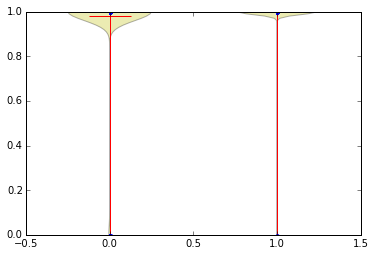

In [572]:
##### ANALYZE RESPONSES #####
import pandas
import scipy as sp

n = X_test.shape[1]

#model.fit(X_train, Y_train[:,-1,0], nb_epoch=20, batch_size=5) # Last sample
#model.fit(X_train, Y_train, nb_epoch=10, batch_size=100, validation_split=0.1)
objective_score = model.evaluate(X_test, Y_test[:,-1,:], batch_size=100)
print('Objective score (',params.final_layer_type,') :: ',score)

test_prediction = model.predict(X_test[:n,:,:])
test_prediction_round = np.round(test_prediction)
# print a.shape
# for i in range(a.shape[0]):
#     plt.plot(a[i,])
#     plt.ylim( (0,1) )
print ('Shape of y_test :: ',Y_test[:n,-1,:].shape)
print ('Uniques in y_test :: ', np.unique(Y_test[:n,-1,:]))
print ('Shape of test_prediction :: ',test_prediction.shape)
print ('Uniques in test_prediction       :: ', np.unique(test_prediction))
print ('Uniques in test_prediction_round :: ', np.unique(test_prediction_round))
uniques = np.unique(test_prediction_round)
print('Sum of test_prediction_round = uniques[0] :: ',uniques[0],' :: ',sum(test_prediction_round == uniques[0]))
print('Sum of test_prediction_round = uniques[1] :: ',uniques[1],' :: ',sum(test_prediction_round == uniques[1]))



# Pull responses and run t-test
def pred_score(target):
    return test_prediction_round[np.where(Y_test[:n,-1,0] == target)]
def p_stars(p_value):
    if p < 0.01: return '*'
    return ''

# PLOT RESPONSES
plt.plot( Y_test[:n,-1,0], test_prediction[:n,0],'.')
plt.violinplot( (pred_score(choice_values[0]),pred_score(choice_values[1])), 
               positions=choice_values,showmeans=True)
plt.xlim(np.asarray(choice_values) + [-0.5,0.5])

# MEAN RESPONSE VALUES
print('Choice ',choice_values[0],' :: ',np.mean(pred_score(choice_values[0])),'+/-',  np.var(pred_score(choice_values[0])))
print('Choice ',choice_values[1],' :: ',np.mean(pred_score(choice_values[1])),'+/-', np.var(pred_score(choice_values[1])))

# STATS
[_,p] = sp.stats.ttest_ind(pred_score(choice_values[0]),pred_score(choice_values[1]))
print('p(distributions of response variables are identical) == ',p[0],' ',p_stars(p))

# Crosstab
pandas.crosstab( np.ravel(test_prediction_round), np.ravel(Y_test[:n,-1,0]) ,rownames=['Prediction'],colnames=['actual'])
